# Proyecto

### BD: accidentes.csv

### Autor: Ortiz Barbosa Carlos Alberto

In [1]:
# Importación de los modulos necesarios
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import shapely
from shapely.geometry import Point
import pysal as ps
import rtree

In [2]:
#Leer el CSV, ordenando por Date 
accidentes = pd.read_csv('../data/accidentes.csv', parse_dates = ['Date'],encoding = 'utf-8').sort_values('Date').reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = accidentes[['City']]

s = df.groupby(df.columns.tolist(), as_index=False).size()
out = s[s > 1].reset_index()
out.rename(columns = {0: 'Num Accidentes'}, inplace=True)
out

,City,Num Accidentes
0,CDMX,38357
1,Desconocida,1558
2,Guadalajara,1371
3,Monterrey,1039
4,Mérida,49
5,Toluca,117


In [4]:
#Elegimos la cuidad de mexico
accidentes_estado = accidentes.loc[ accidentes['City'] == 'CDMX' ]

In [5]:
#Creacion de un campo que contiene un String del dia para usarlo mas adelante
accidentes_estado['DateStr'] = accidentes_estado.Date.apply(lambda x: x.strftime("%Y-%m-%d"))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
#Identicamos los accidentes de las categorias de la BD
es_accidente = accidentes_estado.Category == 'Accidente'

In [7]:
#Identificamos aquellos accidentes que fueron cometidos en los ultimos 20 dias
recientes = accidentes_estado.Date.isin(accidentes_estado.Date.unique()[-30:]) 

In [8]:
accidentes = accidentes_estado[es_accidente & recientes].drop_duplicates('AccidentID').reset_index(drop = True)
accidentes = accidentes[['AccidentID', 'Description', 'DateStr', 'Time', 'Direction','Longitude', 'Latitude']]
print ('{} accidentes en los ultimos 30 dias'.format(str(len(accidentes))))

375 accidentes en los ultimos 30 dias


In [9]:
#Se crea una GeoSerie de las locaciones convertidas a Shapely geometry objects, colocamos el crs a 4326
accidente_geo = gpd.GeoSeries(accidentes.apply(lambda z: Point( z['Longitude'], z['Latitude']), 1),crs={'init': 'epsg:4326'})

#Creacion de un Geodataframe
accidentes = gpd.GeoDataFrame(accidentes.drop(['Longitude', 'Latitude'], 1), geometry=accidente_geo)
print (accidentes.head())

  AccidentID                                        Description     DateStr  \
0     224906  Eje 1 Oriente Boleo: Percance vehicular a la a...  2015-12-01   
1     224870  Anillo Periférico: Percance vial a la altura d...  2015-12-01   
2     224952  Marina Nacional: Percance vehicular a la altur...  2015-12-01   
3     224958  Periférico: Percance vehicular a la altura de ...  2015-12-01   
4     224962  Periférico: Percance vehicular a la altura de ...  2015-12-01   

    Time Direction                                  geometry  
0  15:57       189      POINT (-99.1244452447 19.4533940862)  
1  02:30       196  POINT (-99.19402241709999 19.4102794081)  
2  20:00       152      POINT (-99.1763553768 19.4407506779)  
3  20:47       357      POINT (-99.1921502352 19.4036386514)  
4  21:42       149       POINT (-99.1910760105 19.399911487)  


In [10]:
#Creacion de un mapa Folium, georeferenciando en las coordenadas 19, -99, y con un zoom inicial de 6
mapa_accidentes = folium.Map([19.00, -99.00], zoom_start = 6)

def anadir_puntos_cluster(mapobj, gdf, lista_popups):
    #Creamos una lista vacia, que va a contener las corrdenadas y los puntos popup de informacion
    coords, popups = [], [] 
    
    for i, row in gdf.iterrows():
        #Se añaden la longitud y latitud a coord
        coords.append([row.geometry.y, row.geometry.x])
        #Creacion de un String HTML para usarlos en el despliegue del Popup
        label = '<br>'.join([row[field] for field in lista_popups])
        #Añade a popups el codigo HTML con un size definido para mostrar
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Crear una capa FeatureGroup; puedes poner cosas en él y manejarlas como una sola capa.
    #Por ejemplo, se puede agregar un LayerControl para marcar / desmarcar todo el grupo.
    accidentes_layer = folium.FeatureGroup(name = 'accidentes_layer')

    #Añadimos los grupos de puntos y los popups a la capa FeatureGroup para mostrar
    accidentes_layer.add_children(MarkerCluster(locations = coords, popups = popups))
    
    #Se añade la capa de FeatureGroup al mapa
    mapobj.add_children(accidentes_layer)
    return mapobj

#Añadimos los grupos de puntos 
mapa_accidentes = anadir_puntos_cluster(mapa_accidentes, accidentes, ['Description','Direction','DateStr','Time'])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [11]:
folium.LayerControl().add_to(mapa_accidentes)
mapa_accidentes.save('MAPA_accidentes.html')
mapa_accidentes

In [12]:
df = accidentes_estado[['Category']]

s = df.groupby(df.columns.tolist(), as_index=False).size()
out = s[s > 1].reset_index()
out.rename(columns = {0: 'Num. Accidentes'}, inplace=True)
out

,Category,Num. Accidentes
0,Abierto,620
1,Accidente,6171
2,Accidente Grave,335
3,Alerta,1111
4,Cortes Intermitentes,1067
5,Evento,540
6,Huelga/Plantón,74
7,Incidentes,11687
8,Inundación,475
9,Manifestación,3618


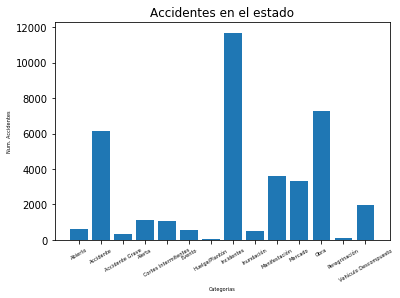

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
%matplotlib inline

label = out['Category']

num_accidentes = out['Num. Accidentes']

index = np.arange(len(label))

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, num_accidentes)
    plt.xlabel('Categorias', fontsize=5)
    plt.ylabel('Num. Accidentes', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Accidentes en el estado')
    pylab.savefig('barChart.pdf')
    plt.show()

plot_bar_x() 

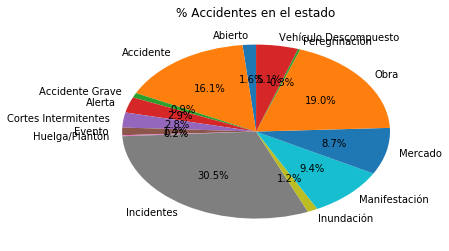

In [14]:
province_population = out['Num. Accidentes']
activities = out['Category']

plt.pie(province_population, labels=activities, startangle=90, autopct='%.1f%%')
plt.title('% Accidentes en el estado')
plt.savefig('pieChart.pdf')
#plt.show() inline hace inecesario esta lines